# Load Data

In [44]:
from pathlib import Path
import polars as pl
import datetime as dt
from tools.database import LoadFromLocal
import math

DATA_ROOT = './data'

def csv_to_df(filename: str, dtype: dict = None, pdates: bool = True, sep: str = ',') -> pl.LazyFrame:
    return pl.read_csv(Path(DATA_ROOT, filename), 
                       try_parse_dates=pdates, 
                       truncate_ragged_lines=True, 
                       infer_schema_length=None, 
                       schema_overrides=dtype,
                       separator=sep).lazy()

In [3]:
TEAMS = csv_to_df('teams.csv', sep=';')
SHIFTS = csv_to_df('shifts.csv')
ROSTERS = csv_to_df('rosters.csv')
PLAYS = csv_to_df('plays.csv', {'situationCode': pl.String})
PLAY_DETAILS = csv_to_df('play_details.csv')
GAMES = csv_to_df('games.csv', pdates=True)

In [4]:
COMBINED_PLAYS = PLAYS.join(PLAY_DETAILS, on=['gameId', 'eventId']).join(GAMES.select(['id', 'homeTeamId', 'awayTeamId', 'gameType', 'season']), left_on='gameId', right_on="id")

In [5]:
SHOTTYPES = PLAY_DETAILS.select(['shotType']).unique().with_columns(
    shotTypeId=pl.col('shotType').cum_count()
)
SHOTTYPES.collect()

shotType,shotTypeId
str,u32
"""tip-in""",1
"""wrist""",2
"""snap""",3
"""backhand""",4
"""slap""",5
…,…
"""cradle""",8
"""wrap-around""",9
null,9


In [20]:
# setting up some constants
SHOT_CAT_DESC_KEY = ['shot-on-goal', 'blocked-shot', 'missed-shot', 'goal']
SHOOTOUT_SITUATION_CODE = ["1010", "0101"]
REGPERIOD_SEC = 20 * 60
PLAYOFFS_OT_SEC = 20 * 60
REGSEAZN_OT_SEC = 5 * 60
RUSH_WINDOW_SEC = 4
REBOUND_WINDOW_SEC = 4
ABS_NET_POS_X = 100 - 11

# Data tables

In [16]:
TEAMS.collect().shape, TEAMS.head(1).collect()

((32, 9),
 shape: (1, 9)
 ┌────────┬───────┬────────┬───────────┬───┬────────────────────┬─────────┬─────────┬───────────────┐
 │ teamid ┆ name  ┆ abbrev ┆ placename ┆ … ┆ darklogo           ┆ color1  ┆ color2  ┆ fullname      │
 │ ---    ┆ ---   ┆ ---    ┆ ---       ┆   ┆ ---                ┆ ---     ┆ ---     ┆ ---           │
 │ i64    ┆ str   ┆ str    ┆ str       ┆   ┆ str                ┆ str     ┆ str     ┆ str           │
 ╞════════╪═══════╪════════╪═══════════╪═══╪════════════════════╪═════════╪═════════╪═══════════════╡
 │ 24     ┆ Ducks ┆ ANA    ┆ Anaheim   ┆ … ┆ https://assets.nhl ┆ #00004E ┆ #FFB81C ┆ Anaheim Ducks │
 │        ┆       ┆        ┆           ┆   ┆ e.com/logos/…      ┆         ┆         ┆               │
 └────────┴───────┴────────┴───────────┴───┴────────────────────┴─────────┴─────────┴───────────────┘)

In [17]:
SHIFTS.collect().shape, SHIFTS.head(1).collect()

((1851750, 13),
 shape: (1, 13)
 ┌──────────┬────────────┬──────────┬──────────┬───┬────────────┬──────────┬────────┬──────────┐
 │ id       ┆ detailCode ┆ duration ┆ playerId ┆ … ┆ gameId     ┆ hexValue ┆ teamId ┆ typeCode │
 │ ---      ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---      │
 │ i64      ┆ i64        ┆ str      ┆ i64      ┆   ┆ i64        ┆ str      ┆ i64    ┆ i64      │
 ╞══════════╪════════════╪══════════╪══════════╪═══╪════════════╪══════════╪════════╪══════════╡
 │ 12438645 ┆ 0          ┆ 01:01    ┆ 8471699  ┆ … ┆ 2022020365 ┆ #6F263D  ┆ 21     ┆ 517      │
 └──────────┴────────────┴──────────┴──────────┴───┴────────────┴──────────┴────────┴──────────┘)

In [63]:
PLAYS.collect().shape, PLAYS.head(1).collect()

((767648, 10),
 shape: (1, 10)
 ┌────────────┬─────────┬────────┬────────────┬───┬──────────┬─────────────┬───────────┬────────────┐
 │ gameId     ┆ eventId ┆ period ┆ periodType ┆ … ┆ typeCode ┆ typeDescKey ┆ sortOrder ┆ homeTeamDe │
 │ ---        ┆ ---     ┆ ---    ┆ ---        ┆   ┆ ---      ┆ ---         ┆ ---       ┆ fendingSid │
 │ i64        ┆ i64     ┆ i64    ┆ str        ┆   ┆ i64      ┆ str         ┆ i64       ┆ e          │
 │            ┆         ┆        ┆            ┆   ┆          ┆             ┆           ┆ ---        │
 │            ┆         ┆        ┆            ┆   ┆          ┆             ┆           ┆ str        │
 ╞════════════╪═════════╪════════╪════════════╪═══╪══════════╪═════════════╪═══════════╪════════════╡
 │ 2022020365 ┆ 51      ┆ 1      ┆ REG        ┆ … ┆ 520      ┆ period-star ┆ 8         ┆ left       │
 │            ┆         ┆        ┆            ┆   ┆          ┆ t           ┆           ┆            │
 └────────────┴─────────┴────────┴────────────┴───┴

In [19]:
PLAY_DETAILS.collect().shape, PLAY_DETAILS.head(1).collect()

((767648, 37),
 shape: (1, 37)
 ┌────────────┬─────────┬──────────────┬─────────────┬───┬─────────────┬────────┬────────┬──────────┐
 │ gameId     ┆ eventId ┆ assist1Playe ┆ assist1Play ┆ … ┆ winningPlay ┆ xCoord ┆ yCoord ┆ zoneCode │
 │ ---        ┆ ---     ┆ rId          ┆ erTotal     ┆   ┆ erId        ┆ ---    ┆ ---    ┆ ---      │
 │ i64        ┆ i64     ┆ ---          ┆ ---         ┆   ┆ ---         ┆ i64    ┆ i64    ┆ str      │
 │            ┆         ┆ i64          ┆ i64         ┆   ┆ i64         ┆        ┆        ┆          │
 ╞════════════╪═════════╪══════════════╪═════════════╪═══╪═════════════╪════════╪════════╪══════════╡
 │ 2022020365 ┆ 51      ┆ null         ┆ null        ┆ … ┆ null        ┆ null   ┆ null   ┆ null     │
 └────────────┴─────────┴──────────────┴─────────────┴───┴─────────────┴────────┴────────┴──────────┘)

In [20]:
ROSTERS.collect().shape, ROSTERS.head(1).collect()

((97052, 6),
 shape: (1, 6)
 ┌────────┬──────────┬───────────────┬──────────────┬─────────────────────────────────┬────────────┐
 │ teamId ┆ playerId ┆ sweaterNumber ┆ positionCode ┆ headshot                        ┆ gameId     │
 │ ---    ┆ ---      ┆ ---           ┆ ---          ┆ ---                             ┆ ---        │
 │ i64    ┆ i64      ┆ i64           ┆ str          ┆ str                             ┆ i64        │
 ╞════════╪══════════╪═══════════════╪══════════════╪═════════════════════════════════╪════════════╡
 │ 7      ┆ 8467950  ┆ 41            ┆ G            ┆ https://assets.nhle.com/mugs/n… ┆ 2022020365 │
 └────────┴──────────┴───────────────┴──────────────┴─────────────────────────────────┴────────────┘)

In [21]:
GAMES.collect().shape, GAMES.head(1).collect()

((2427, 7),
 shape: (1, 7)
 ┌────────────┬──────────┬──────────┬──────────────┬──────────────────┬────────────┬────────────┐
 │ id         ┆ season   ┆ gameType ┆ startTimeUTC ┆ venueTimezone    ┆ awayTeamId ┆ homeTeamId │
 │ ---        ┆ ---      ┆ ---      ┆ ---          ┆ ---              ┆ ---        ┆ ---        │
 │ i64        ┆ i64      ┆ i64      ┆ datetime[μs, ┆ str              ┆ i64        ┆ i64        │
 │            ┆          ┆          ┆ UTC]         ┆                  ┆            ┆            │
 ╞════════════╪══════════╪══════════╪══════════════╪══════════════════╪════════════╪════════════╡
 │ 2022020365 ┆ 20222023 ┆ 2        ┆ 2022-12-02   ┆ America/New_York ┆ 21         ┆ 7          │
 │            ┆          ┆          ┆ 00:00:00 UTC ┆                  ┆            ┆            │
 └────────────┴──────────┴──────────┴──────────────┴──────────────────┴────────────┴────────────┘)

In [35]:
COMBINED_PLAYS.head(1).collect()

gameId,eventId,period,periodType,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,homeTeamDefendingSide,assist1PlayerId,assist1PlayerTotal,assist2PlayerId,assist2PlayerTotal,awaySOG,awayScore,blockingPlayerId,committedByPlayerId,descKey,discreteClip,drawnByPlayerId,duration,eventOwnerTeamId,goalieInNetId,highlightClip,highlightClipFr,highlightClipSharingUrl,highlightClipSharingUrlFr,hitteePlayerId,hittingPlayerId,homeSOG,homeScore,losingPlayerId,playerId,reason,scoringPlayerId,scoringPlayerTotal,secondaryReason,shootingPlayerId,shotType,typeCode_right,winningPlayerId,xCoord,yCoord,zoneCode,homeTeamId,awayTeamId,gameType
i64,i64,i64,str,str,i64,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,i64,i64,i64,str,i64,i64,i64
2022020365,51,1,"""REG""","""00:00""",1551,520,"""period-start""",8,"""left""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7,21,2


### Investigating Net location mapping

Seems like the `homeTeamDefendingSide` isn't very reliable as an indicator of location mapping, and 
possibly zodeCode too

In [ ]:
COMBINED_PLAYS.collect()('homeTeamDefendingSide').value_counts()

homeTeamDefendingSide,count
str,u32
"""right""",392658
"""left""",374990


In [27]:
(
    COMBINED_PLAYS
    .filter(pl.col('xCoord').is_not_null())
    .with_columns(
        isHomeEvent=pl.col('eventOwnerTeamId') == pl.col('homeTeamId'),
        # assume consistently left means net.xcoord > 0, right means net.xcoord < 0
        homeTeamNetX=pl.when(pl.col('homeTeamDefendingSide') == pl.lit('left')).then(pl.lit(100)).otherwise(pl.lit(-100)),
        awayTeamNetX=pl.when(pl.col('homeTeamDefendingSide') == pl.lit('left')).then(pl.lit(-100)).otherwise(pl.lit(100)),
    )
    .with_columns(
        netX=pl.when(pl.col('isHomeEvent')).then(pl.col('homeTeamNetX')).otherwise(pl.col('awayTeamNetX')),
        isHomeEventId=pl.when(pl.col('isHomeEvent')).then(pl.lit(1)).otherwise(pl.lit(-1)),
    )
    .with_columns(isConsistent=pl.col('isHomeEventId').mul(pl.col('netX')).mul('xCoord') >= 0)
    .select([
        'xCoord', 'isHomeEvent', 'netX', 'typeDescKey',
        'zoneCode', 'isConsistent',
        # 'homeTeamNetX', 'awayTeamNetX', 
    ])
    .filter(pl.col('isConsistent'))
    .collect()
)

xCoord,isHomeEvent,netX,typeDescKey,zoneCode,isConsistent
i64,bool,i32,str,str,bool
0,true,100,"""faceoff""","""N""",true
47,true,100,"""shot-on-goal""","""O""",true
74,true,100,"""blocked-shot""","""D""",true
76,true,100,"""missed-shot""","""O""",true
98,false,-100,"""hit""","""D""",true
…,…,…,…,…,…
2,true,100,"""shot-on-goal""","""N""",true
5,false,-100,"""giveaway""","""N""",true
20,true,100,"""faceoff""","""N""",true


In [28]:
(
    COMBINED_PLAYS
    .filter(pl.col('xCoord').is_not_null())
    .filter(pl.col('zoneCode').is_in(['O', 'D']))
    .join(GAMES, left_on="gameId", right_on="id")
    .with_columns(
        isHomeEventInt=pl.when(pl.col('eventOwnerTeamId') == pl.col('homeTeamId')).then(1).otherwise(-1),
        isOffense=pl.when(pl.col('zoneCode') == pl.lit('O')).then(1).otherwise(-1),
    )
    .with_columns(
        isConsistent=pl.col('isHomeEventInt').mul(pl.col('isOffense')).mul(pl.col('xCoord')) > 0
    )
    # .with_columns(isConsistent=pl.col('isHomeEventId').mul(pl.col('netX')).mul('xCoord') >= 0)
    .select([
        'typeDescKey', 'isHomeEventInt', 'isOffense', 
        'xCoord', 'zoneCode', 'isConsistent',
        # 'homeTeamNetX', 'awayTeamNetX', 
    ])
    .filter(pl.col('isConsistent').not_())
    .collect()
)

typeDescKey,isHomeEventInt,isOffense,xCoord,zoneCode,isConsistent
str,i32,i32,i64,str,bool
"""blocked-shot""",1,-1,74,"""D""",false
"""blocked-shot""",1,-1,74,"""D""",false
"""blocked-shot""",1,-1,58,"""D""",false
"""blocked-shot""",-1,-1,-69,"""D""",false
"""blocked-shot""",-1,-1,-72,"""D""",false
…,…,…,…,…,…
"""blocked-shot""",1,-1,72,"""D""",false
"""blocked-shot""",-1,-1,-83,"""D""",false
"""blocked-shot""",1,-1,57,"""D""",false


### Checking penalty shot situationCode

In [54]:
(
    COMBINED_PLAYS
    # .filter(pl.col('typeDescKey') == 'penalty-shot')
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).and_(pl.col('period') <= 3))
    .select(['typeDescKey', 'situationCode'])
    .collect()
)

typeDescKey,situationCode
str,str
"""shot-on-goal""","""1010"""
"""shot-on-goal""","""1010"""
"""shot-on-goal""","""1010"""
"""shot-on-goal""","""1010"""
"""goal""","""0101"""
"""failed-shot-attempt""","""0101"""
"""goal""","""1010"""
"""shot-on-goal""","""1010"""
"""shot-on-goal""","""1010"""


# Transforming Data

## Feature engineering

- doesn't do too well with too many parameters
- first attempt at a basic model

Features to use:

| feature | description | is parameter |
| ------- | ----------- | ------------ |
| `typeDescKey` | event desc | y |
| `sortOrder` | canonical order of events | n |
| `period` | periodId | y |
| `periodType` | REG / OT (filter out SO) | n |
| `eventOwnerTeamId` | event owner team id | y |
| `xCoord` | rink xcoords (N/S) | n |
| `yCoord` | rink ycoords (E/W) | n |

Features to add:

| feature | description | is parameter | added | 
| ------- | ----------- | ------------ | ----- |
| `deltaTime` | time since last event (any) | n | y | 
| `deltaTimeHomeShot` | time since last home shot | n | y |
| `deltaTimeHomeShot` | time since last away shot | n | y |
| `deltaDist` | distance since last event (any) | n | y |
| `deltaDistNet` | distance from owner team's net | n |  |
| `shotAngle` | angle of shot from center North/South line | n |  |
| `deltaAngle` | change in angle since last shot | n |  |
| `rebound` | 0 / 1 (last shot by same team within 4 seconds) | n | y |
| `rush` | 0 / 1 (last shot by diff team from opposite end within 4 seconds) | n | y |
| `goal` | 0 / 1 | n | y |
| `shot` | 0 / 1 | n | y |
| `block` | 0 / 1 | n | y |
| `miss` | 0 / 1 | n | y |
| `isHome` | True / False | n | y |
| `homeGf` | cumsum | n | y |
| `homeSog` | cumsum | n | y |
| `homeBlocked` | cumsum | n | y |
| `homeMiss` | cumsum | n | y |
| `homeCf` |  shots + blocks + misses | y | y |
| `homeFf` |  shots + misses | y | y |
| `awayGf` | cumsum | n | y |
| `awaySog` | cumsum | n | y |
| `awayBlocked` | cumsum | n | y |
| `awayMiss` | cumsum | n | y |
| `awayCf` |  shots + blocks + misses | y | y |
| `awayFf` |  shots + misses | y | y |
| `gDiff` | homeGoal - awayGoal | n |  |
| `homeSkt` | home num of skaters | n | y |
| `homeEn` | invert `homeGoalie` | y | y |
| `awaySkt` | away num of skaters | n | y |
| `awayEn` | invert `awayGoalie` | y | y |
| `otLengthSec` | if gametype is 2, then `5 * 60`, else `20 * 60` | n | y |
| `timeInPeriodSec` | computed time from start of period | y | y |
| `timeSinceStartSec` | computed time from start of game | n | y |

In [14]:
def time_to_seconds_expr(label: str):
    dt_expr = (
        pl.col(label)
        .str.to_datetime("%H:%M")
    )
    return dt_expr.dt.hour().cast(pl.Int64) * 60 + dt_expr.dt.minute().cast(pl.Int64)

def is_event_by(home_or_away: str):
    return pl.col(f"{home_or_away}TeamId") == pl.col("eventOwnerTeamId")

pl.Config().set_tbl_rows(100);

### Calculating home/away net position

Since neither the `zoneCode` nor `homeTeamDefendingSide` are consistent, we will take Team A's net location as the side the opposing team B shoots more at.

In [39]:
NET_LOCATION_ESTIMATE = (
    COMBINED_PLAYS
    # remove shootouts AND penalty shots
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).not_())
    # sort by gameId and sortOrder
    .sort('sortOrder', descending=False)
    .sort('gameId', descending=False)
    .with_columns(
        goal=pl.when(pl.col('typeDescKey') == 'goal').then(1).otherwise(0),
        shot=pl.when(pl.col('typeDescKey').is_in(SHOT_CAT_DESC_KEY)).then(1).otherwise(0),
    )
    .with_columns(
        homeNetPosXBias=pl.when(pl.col('shot') == 1).then(
            # we're going to determine the position of the home team's net by the majority of where the shots are attempted
            pl.when((is_event_by('away').and_(pl.col('xCoord') > 0)).or_(is_event_by('home').and_(pl.col('xCoord') < 0))).then(1).otherwise(-1)
        ).otherwise(0),
    )
    .with_columns(
        homeNetPosXBias=pl.col('homeNetPosXBias').cum_sum().over(['gameId', 'period'])
    )
    .with_columns(
        homeNetXCoordEst=pl.when(pl.col('homeNetPosXBias') > 0).then(ABS_NET_POS_X).otherwise(-ABS_NET_POS_X),
        awayNetXCoordEst=pl.when(pl.col('homeNetPosXBias') > 0).then(-ABS_NET_POS_X).otherwise(ABS_NET_POS_X),
    )
    .select([
        'gameId', 'period', 'homeNetXCoordEst', 'awayNetXCoordEst', 
        # 'homeNetPosXBias',
        # 'sortOrder', 'typeDescKey'
    ])
    .group_by('gameId', 'period')
    .last()
)
NET_LOCATION_ESTIMATE.collect().sort('period', descending=False).sort('gameId', descending=False).head(10)

gameId,period,homeNetXCoordEst,awayNetXCoordEst
i64,i64,i32,i32
2022020320,1,-89,89
2022020320,2,89,-89
2022020320,3,-89,89
2022020338,1,-89,89
2022020338,2,89,-89
2022020338,3,-89,89
2022020365,1,-89,89
2022020365,2,89,-89
2022020365,3,-89,89


In [60]:
plays = (
    COMBINED_PLAYS
    # remove shootouts AND penalty shots
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).not_())
    # sort by gameId and sortOrder
    .sort('sortOrder', descending=False)
    .sort('gameId', descending=False)
    # join the 
    .join(NET_LOCATION_ESTIMATE, on=['gameId', 'period'])
    .with_columns(
        eventBy=pl.when(is_event_by('home')).then(pl.lit('home')).otherwise(pl.lit('away')),
        goal=pl.when(pl.col('typeDescKey') == 'goal').then(1).otherwise(0),
        shot=pl.when(pl.col('typeDescKey').is_in(SHOT_CAT_DESC_KEY)).then(1).otherwise(0),
        block=pl.when(pl.col('typeDescKey') == 'blocked-shot').then(1).otherwise(0),
        miss=pl.when(pl.col('typeDescKey') == 'missed-shot').then(1).otherwise(0),
        homeEn=pl.col('situationCode').str.starts_with(0),
        awayEn=pl.col('situationCode').str.ends_with(0),
        homeSkt=pl.col('situationCode').str.slice(2,1).str.to_integer(),
        awaySkt=pl.col('situationCode').str.slice(1,1).str.to_integer(),
        timeRemainingSec=time_to_seconds_expr('timeRemaining'),
        numOtPeriods=pl.max_horizontal(pl.lit(0), pl.col('period') - 3),
        numRegPeriods=pl.min_horizontal(pl.lit(3), pl.col('period')),
        otLengthSec=pl.when(pl.col('gameType') == 3).then(PLAYOFFS_OT_SEC).otherwise(REGSEAZN_OT_SEC),
    )
    .with_columns(
        timeSinceStartSec=pl.col('numRegPeriods') * pl.lit(REGPERIOD_SEC) + pl.col('numOtPeriods') * pl.col('otLengthSec') - pl.col('timeRemainingSec'),
        goalByTeamId=pl.when(pl.col('goal') == 1).then(pl.when(is_event_by('home')).then(pl.col('homeTeamId')).otherwise(pl.col('awayTeamId'))).otherwise(None),
        shotByTeamId=pl.when(pl.col('shot') == 1).then(pl.when(is_event_by('home')).then(pl.col('homeTeamId')).otherwise(pl.col('awayTeamId'))).otherwise(None),
        netShotAtXCoord=pl.when(pl.col('shot') == 1).then(pl.when(is_event_by('home')).then(pl.col('awayNetXCoordEst')).otherwise(pl.col('homeNetXCoordEst'))).otherwise(None),
    )
    .with_columns(
        angDeg=pl.when(pl.col('shot') == 1).then(
            (pl.col('yCoord').abs() / (pl.col('xCoord') - pl.col('netShotAtXCoord')).abs()).arctan() / math.pi * 180.0
        ).otherwise(None)
    )
    # per game
    .with_columns(
        homeGf=pl.when((pl.col('goal') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayGf=pl.when((pl.col('goal') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        # Corsi Fors
        homeCf=pl.when((pl.col('shot') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayCf=pl.when((pl.col('shot') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        homeBlocked=pl.when((pl.col('block') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayBlocked=pl.when((pl.col('block') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        homeMiss=pl.when((pl.col('miss') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayMiss=pl.when((pl.col('miss') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
    )
    .with_columns(
        homeGf=pl.col('homeGf').cum_sum().over(['gameId']),
        awayGf=pl.col('awayGf').cum_sum().over(['gameId']),
        homeCf=pl.col('homeCf').cum_sum().over(['gameId']),
        awayCf=pl.col('awayCf').cum_sum().over(['gameId']),
        homeBlocked=pl.col('homeBlocked').cum_sum().over(['gameId']),
        awayBlocked=pl.col('awayBlocked').cum_sum().over(['gameId']),
        homeMiss=pl.col('homeMiss').cum_sum().over(['gameId']),
        awayMiss=pl.col('awayMiss').cum_sum().over(['gameId']),
    )
    .with_columns(
        homeSog=pl.col('homeCf') - pl.col('homeBlocked') - pl.col('homeMiss'),
        awaySog=pl.col('awayCf') - pl.col('awayBlocked') - pl.col('awayMiss'),
        # Fenwick Fors
        homeFf=pl.col('homeCf') - pl.col('homeBlocked'),
        awayFf=pl.col('awayCf') - pl.col('awayBlocked'),
    )
    # per period
    .with_columns(
        # for calculating rush
        lastXCoord=pl.col('xCoord').shift(1).over(['gameId', 'period']).fill_null(0),
        lastYCoord=pl.col('yCoord').shift(1).over(['gameId', 'period']).fill_null(0),
        # for calculating rebound angle
        lastHomeShotXCoord=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('xCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotXCoord=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('xCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastHomeShotYCoord=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('yCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotYCoord=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('yCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastHomeShotAngDeg=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('angDeg')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotAngDeg=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('angDeg')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        # both rush and rebounds will need to look at time
        lastTimeRemainingSec=pl.col('timeRemainingSec').shift(1).over(['gameId', 'period']).fill_null(REGPERIOD_SEC),
        lastHomeShotTimeRemainingSec=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('timeRemainingSec')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotTimeRemainingSec=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('timeRemainingSec')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
    )
    .with_columns(
        deltaTime=pl.col('lastTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaTimeHomeShot=pl.col('lastHomeShotTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaTimeAwayShot=pl.col('lastAwayShotTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaAngDegHomeShot=pl.when(pl.col('angDeg').is_not_null()).then(pl.col('lastHomeShotAngDeg') - pl.col('angDeg')).otherwise(None),
        deltaAngDegAwayShot=pl.when(pl.col('angDeg').is_not_null()).then(pl.col('lastAwayShotAngDeg') - pl.col('angDeg')).otherwise(None),
        deltaXCoord=pl.col('lastXCoord') - pl.col('xCoord'),
        deltaYCoord=pl.col('lastYCoord') - pl.col('yCoord'),
    )
    .with_columns(
        deltaDist=((pl.col('lastXCoord') - pl.col('xCoord')).pow(2) + (pl.col('lastYCoord') - pl.col('yCoord')).pow(2)).pow(0.5),
        rush=pl.when((pl.col('xCoord') * pl.col('lastXCoord') < 0).and_(pl.col('shot') == 1).and_(pl.col('deltaTime') < RUSH_WINDOW_SEC)).then(1).otherwise(0), # time since last event
        # time since last shot
        rebound=pl.when((pl.col('xCoord') * pl.col('lastXCoord') > 0).and_(pl.col('shot') == 1).and_((pl.col('deltaTimeHomeShot') < REBOUND_WINDOW_SEC).or_(pl.col('deltaTimeAwayShot') < REBOUND_WINDOW_SEC))).then(1).otherwise(0) 
    )
    .with_columns(
        speed=pl.col('deltaDist') / pl.col('deltaTime')
    )
    # .filter(pl.col('gameType') == 2)
)
(
    plays
    .select(
        # "*"
        [ 
            'gameId', 'period', 'sortOrder', 'typeDescKey', 'eventBy','situationCode',
            "xCoord", "netShotAtXCoord", 'yCoord', 'shot', 'angDeg',
            'lastAwayShotAngDeg', 'lastHomeShotAngDeg',
            'deltaAngDegHomeShot', 'deltaAngDegAwayShot', 
            # 'goal', 'shot', 
            # 'situationCode', 'timeSinceStartSec', 'numOtPeriods', 'numRegPeriods', 'otLengthSec', 
            # 'homeEn', 'awayEn',
            # 'homeSkt', 'awaySkt',
            # 'homeGf', 'awayGf',
            # 'homeCf', 'awayCf',
            # 'homeFf', 'awayFf',
            # 'homeBlocked', 'awayBlocked',
            # 'homeMiss', 'awayMiss',
            # 'deltaTime', 'deltaTimeHomeShot', 'deltaTimeAwayShot', 'deltaDist',
            # 'rush', 'rebound', 'goalByTeamId', 'shotByTeamId',
            # 'lastHomeShotTimeRemainingSec',
            # 'lastAwayShotTimeRemainingSec',
            # 'lastHomeShotXCoord',
            # 'lastHomeShotYCoord',
            # 'lastAwayShotXCoord',
            # 'lastAwayShotYCoord',
        ]
    )
    # .filter(pl.col('deltaTimeHomeShot') < 0)
    # .filter(pl.col('rebound') == 1)
    # .filter(pl.col('shot') == 1)
    .head(100)
    .collect()
)

gameId,period,sortOrder,typeDescKey,eventBy,situationCode,xCoord,netShotAtXCoord,yCoord,shot,angDeg,lastAwayShotAngDeg,lastHomeShotAngDeg,deltaAngDegHomeShot,deltaAngDegAwayShot
i64,i64,i64,str,str,str,i64,i32,i64,i32,f64,f64,f64,f64,f64
2022020320,1,8,"""period-start""","""away""","""1551""",null,null,null,0,null,null,null,null,null
2022020320,1,11,"""faceoff""","""home""","""1551""",0,null,0,0,null,null,null,null,null
2022020320,1,12,"""hit""","""home""","""1551""",-97,null,9,0,null,null,null,null,null
2022020320,1,13,"""goal""","""away""","""1551""",-44,-89,-28,1,31.890792,null,null,null,null
2022020320,1,16,"""faceoff""","""away""","""1551""",0,null,0,0,null,31.890792,null,null,null
2022020320,1,17,"""giveaway""","""away""","""1551""",90,null,30,0,null,31.890792,null,null,null
2022020320,1,26,"""shot-on-goal""","""away""","""1551""",48,-89,35,1,14.331073,31.890792,null,null,17.559718
2022020320,1,35,"""stoppage""","""away""","""1551""",null,null,null,0,null,14.331073,null,null,null
2022020320,1,37,"""faceoff""","""home""","""1551""",69,null,-22,0,null,14.331073,null,null,null


## Exploration

In [115]:
import matplotlib.pyplot as plt
import draw

In [237]:
team_id_abbrev = TEAMS.select(['teamid', 'abbrev', 'color1', 'color2']).lazy()

In [238]:
def draw_xy_shot(df: pl.DataFrame, title: str, ax = plt, c : pl.Series | str | None = None, filename: str | None = None):
    ax.scatter(df['xCoord'], df['yCoord'], c=c, s=2)
    if ax == plt:
        ax.xlim(draw.RINK[0])
        ax.ylim(draw.RINK[1])
        ax.gca().set_aspect('equal')
        ax.title(title)
    else:
        ax.set_xlim(draw.RINK[0])
        ax.set_ylim(draw.RINK[1])
        ax.set_aspect('equal')
        ax.set_title(title)
        
    if filename:
        ax.savefig(f'./diagrams/{filename}')

In [239]:
def draw_teams_goals(df: pl.LazyFrame, label: str, team_column_label: str):
    fig, axes = plt.subplots(8,4)

    teams = team_id_abbrev.collect().to_dicts()
    for idx, team in enumerate(teams):
        r = idx // 4
        c = idx % 4
        
        draw_xy_shot(
            df.filter(pl.col(team_column_label) == team['teamid']).collect(), 
            label % team['abbrev'],
            ax=axes[r, c],
            c=team['color1']
        )
    fig.set_figheight(20)
    fig.set_figwidth(30)
    return fig, axes

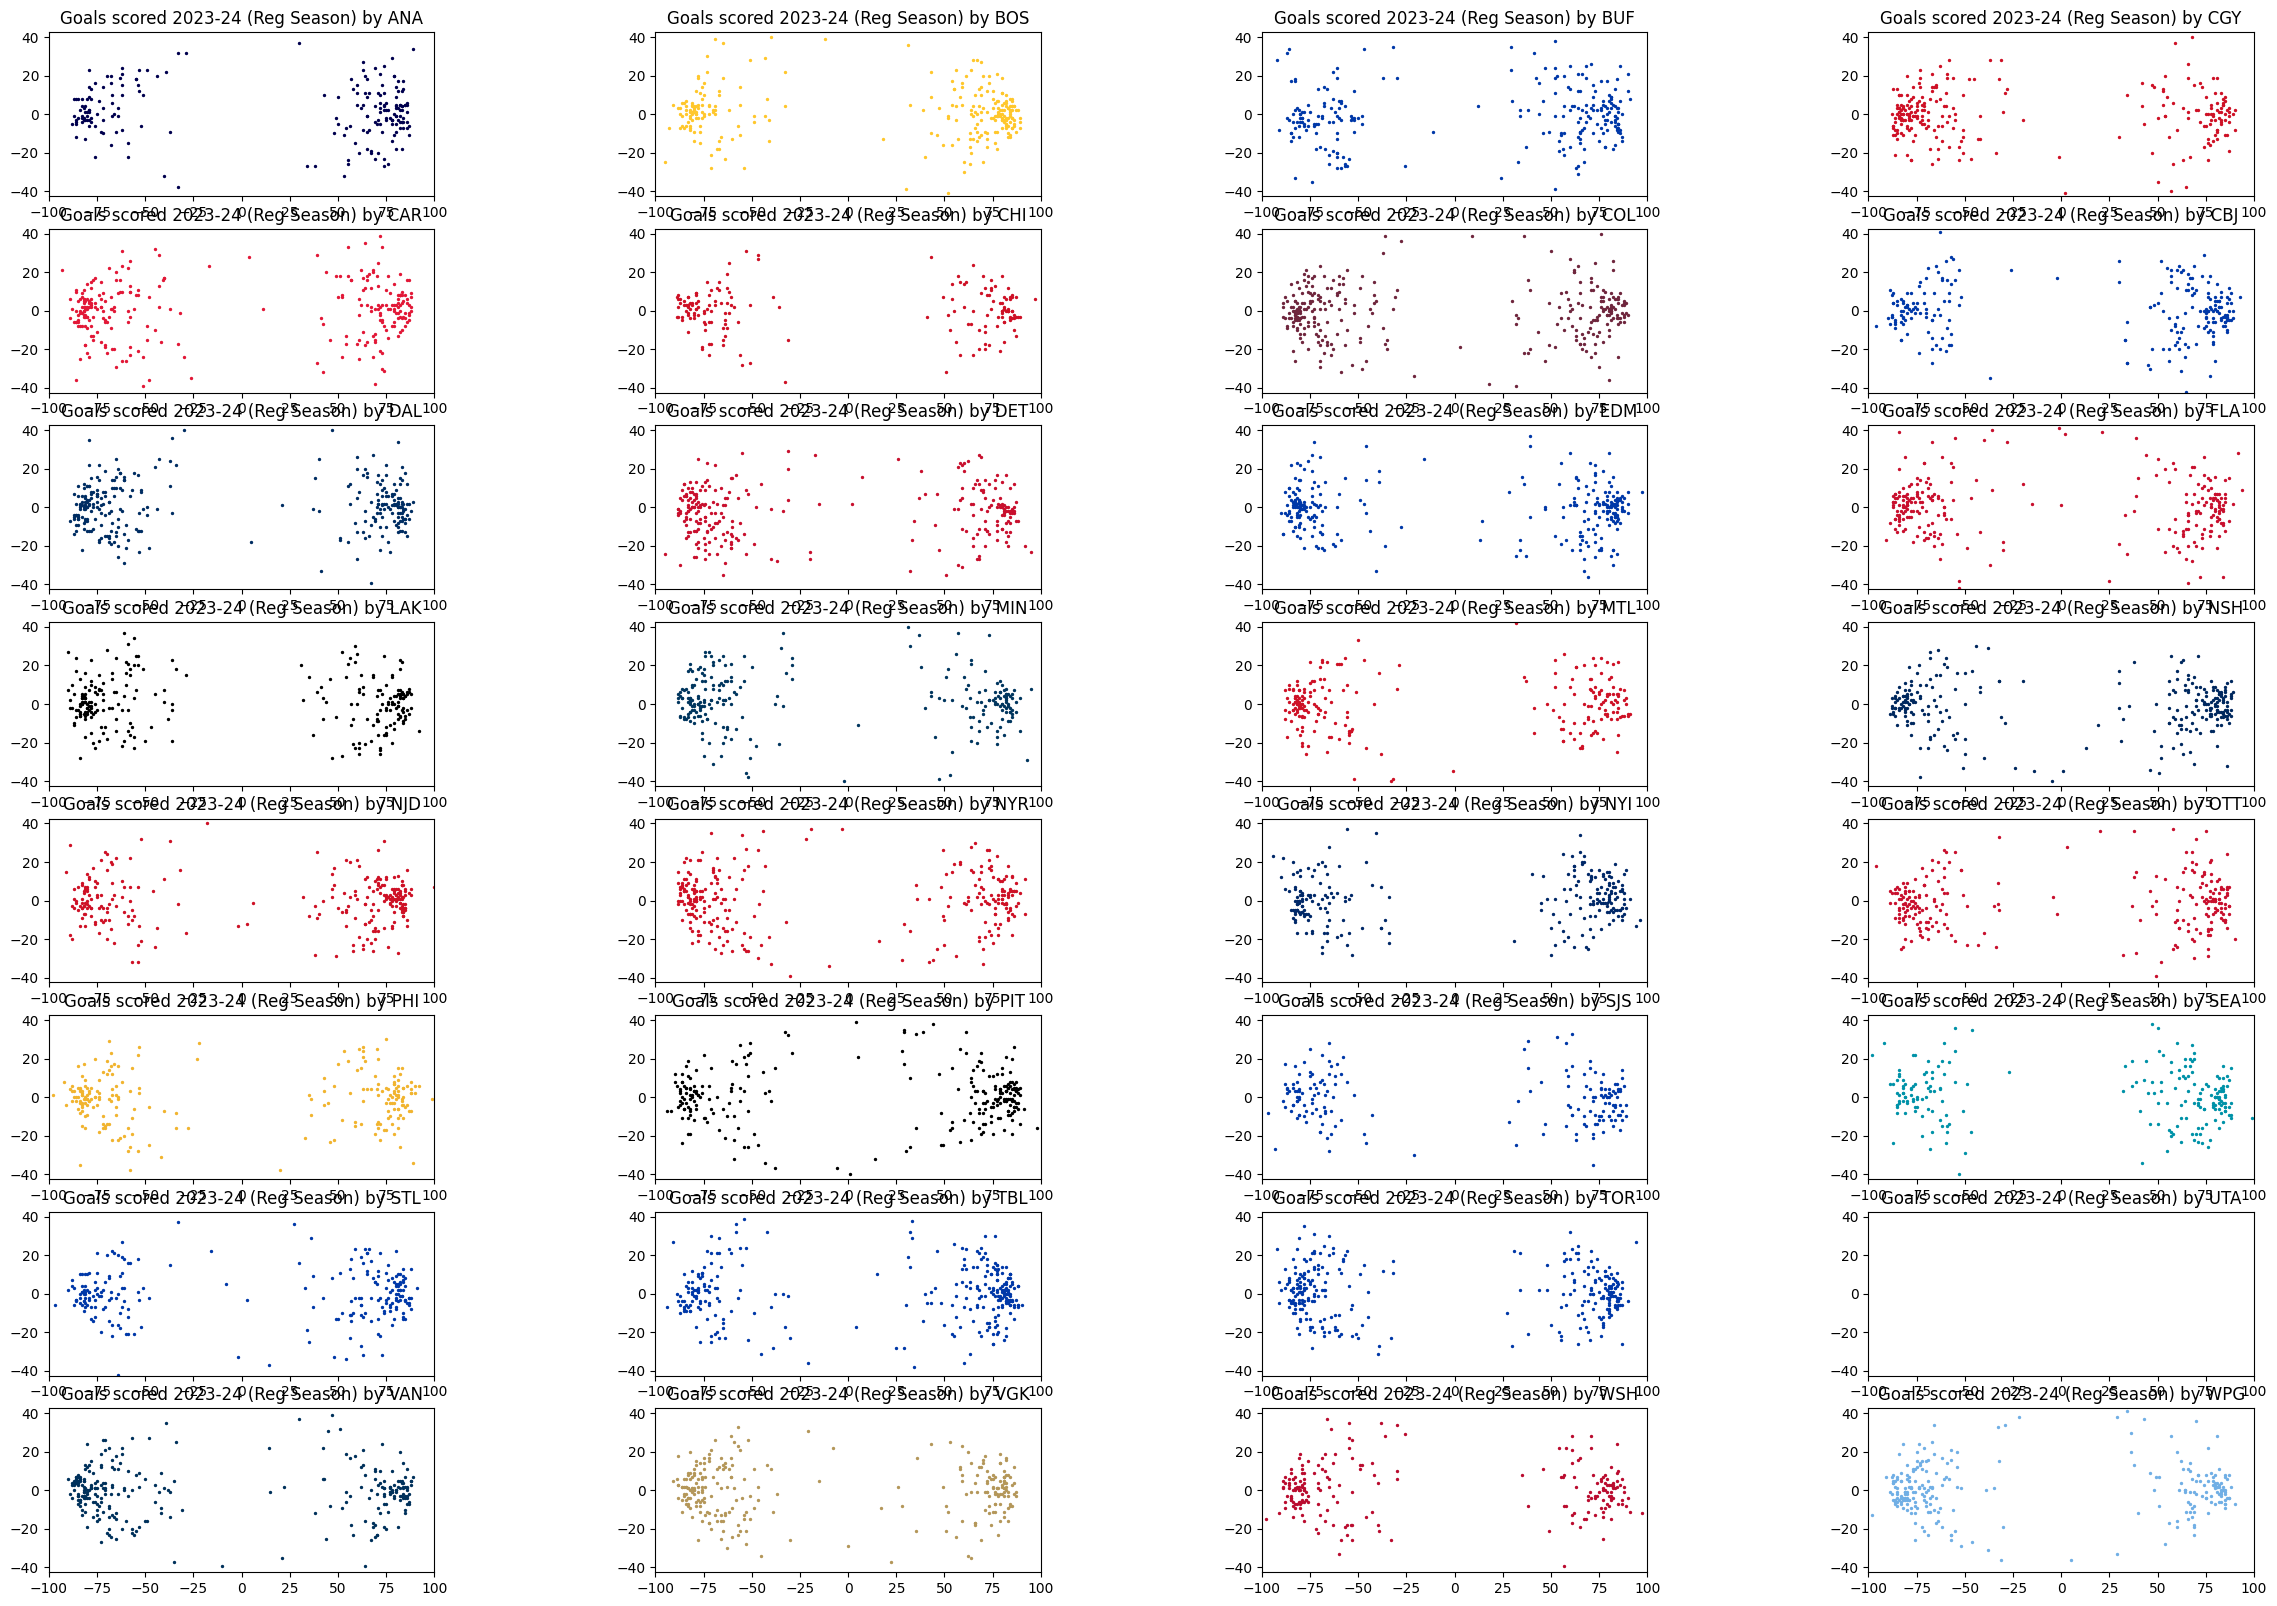

In [193]:
fig, axes = draw_teams_goals(
    plays.filter(pl.col('goal') == 1).filter(pl.col('season') == 20232024).filter(pl.col('gameType') == 2), 
    "Goals scored 2023-24 (Reg Season) by %s",
    'goalByTeamId'
)

#### Rush goals

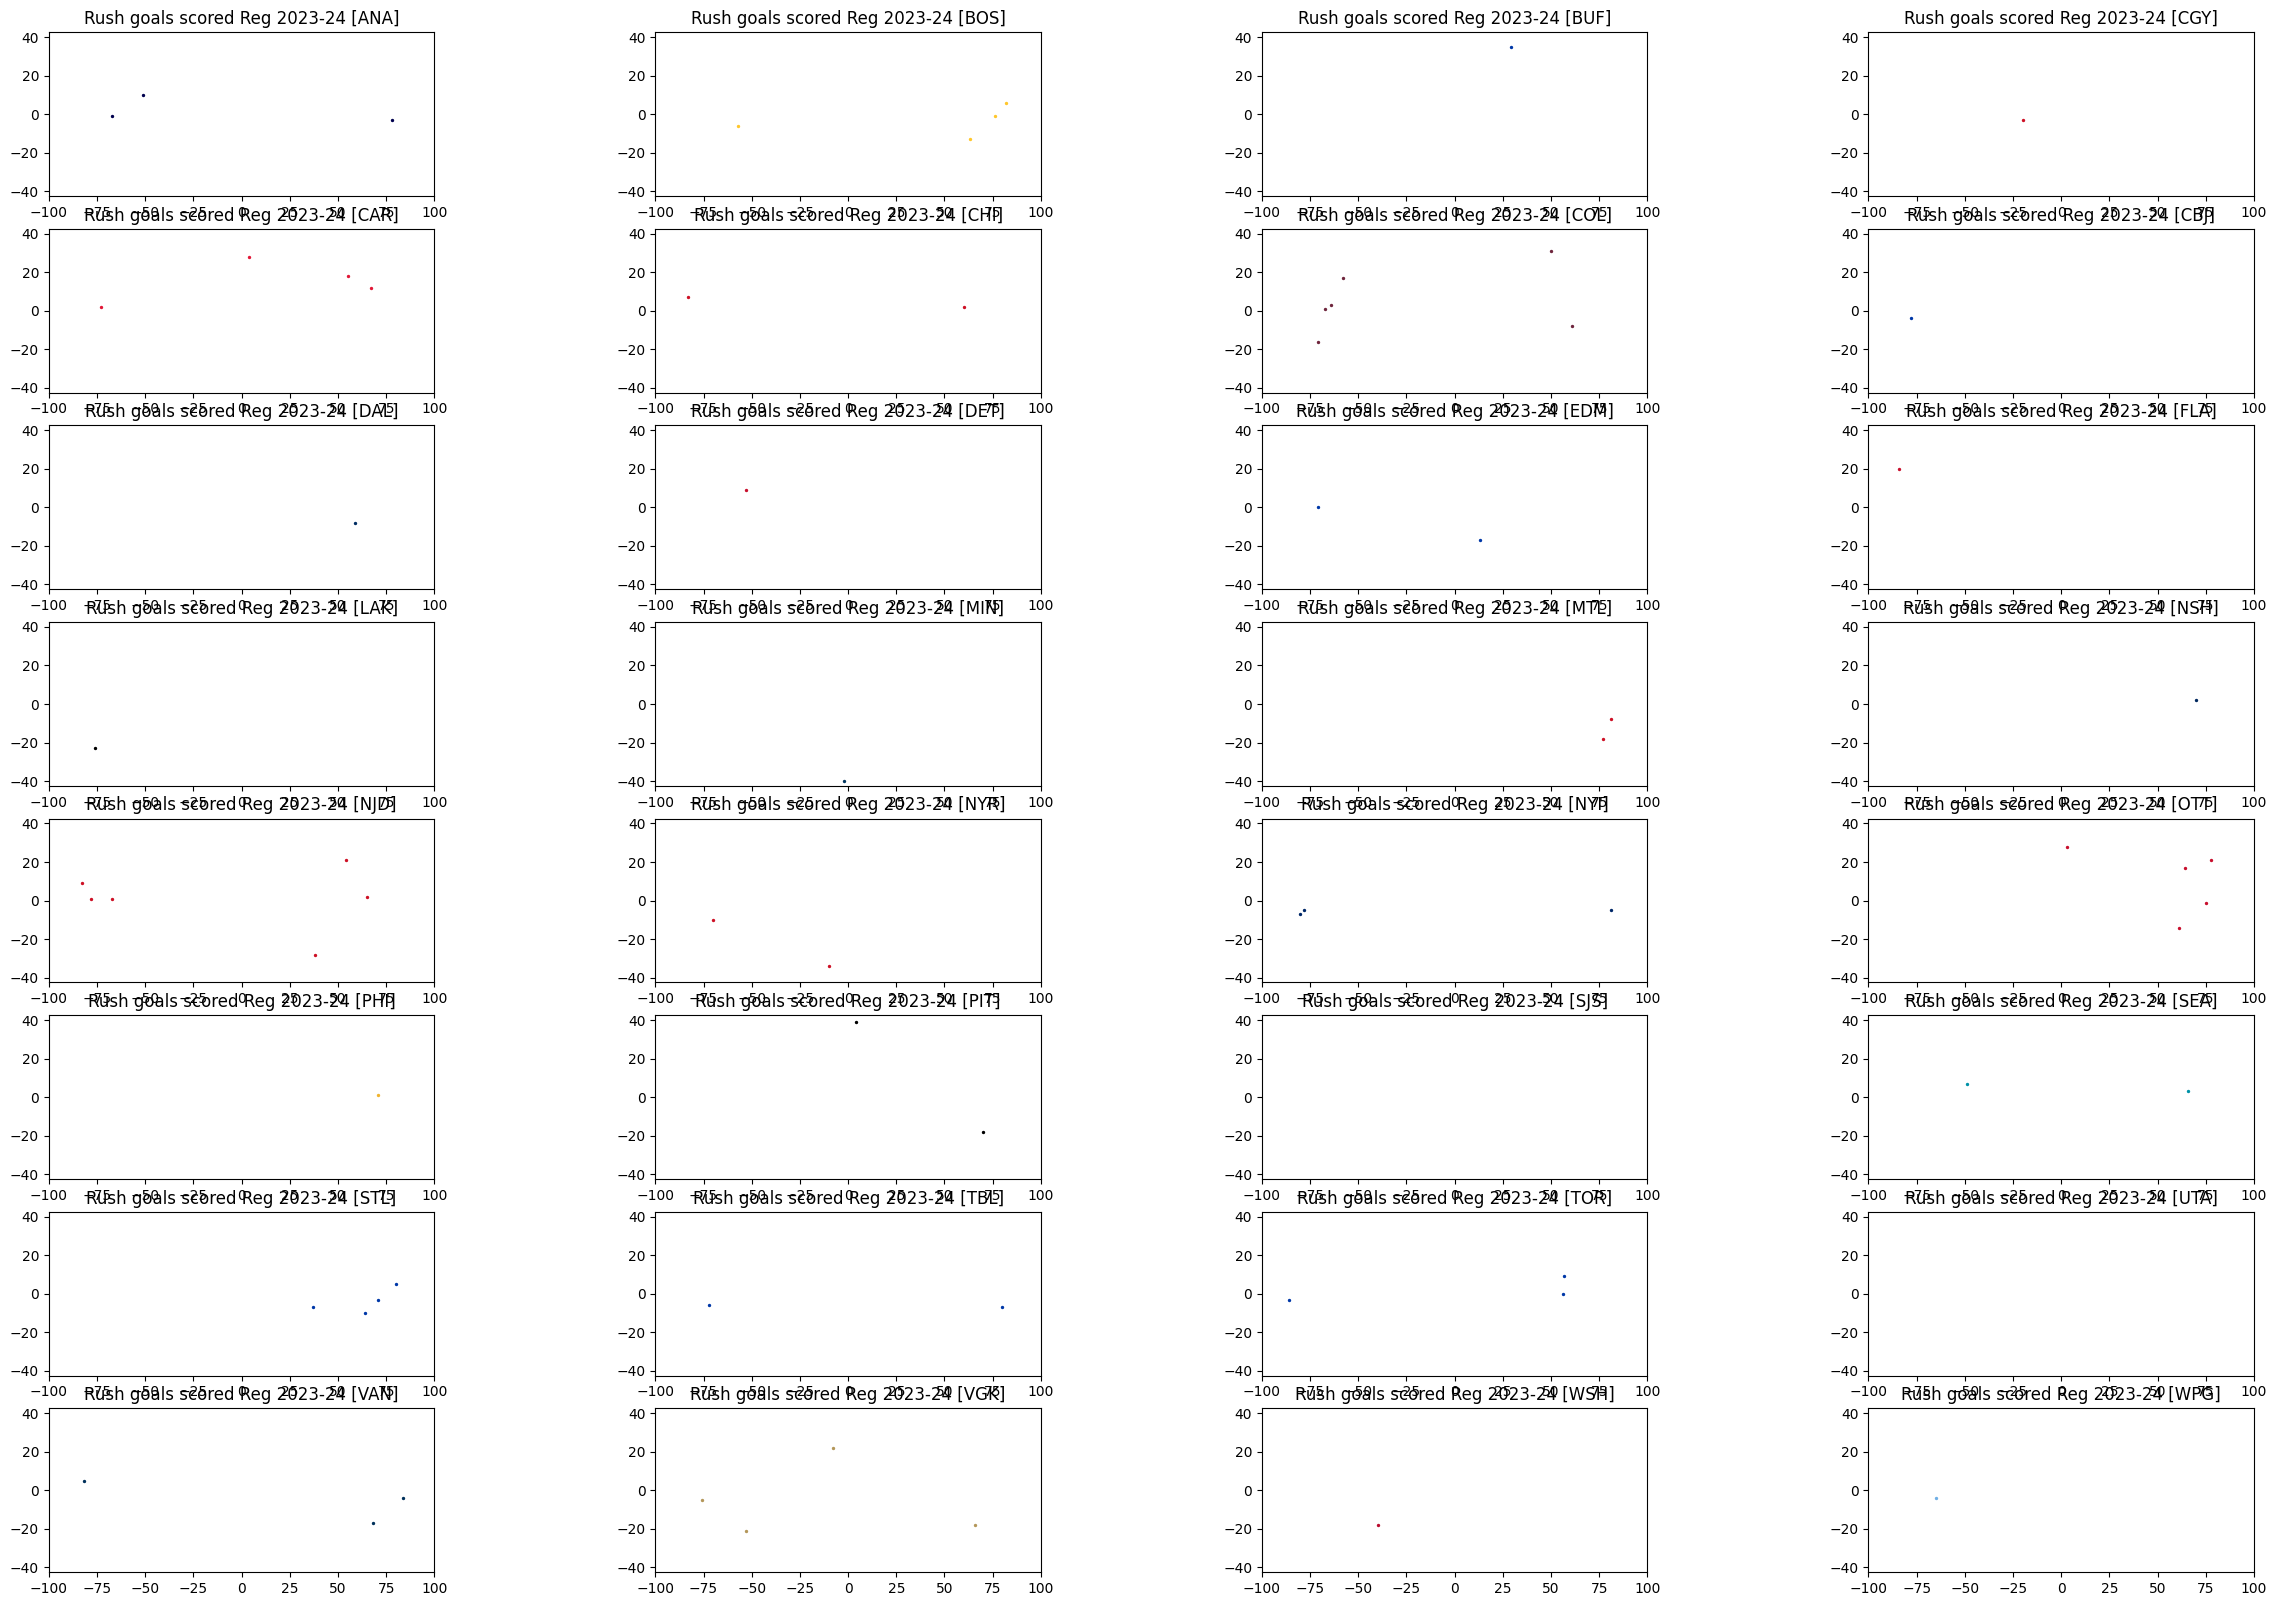

In [207]:
rush_all = (
    plays
    .filter(pl.col('rush') == 1)
    .filter(pl.col('season') == 20232024)
    .filter(pl.col('gameType') == 2)
)
fig, axes = draw_teams_goals(
    rush_all.filter(pl.col('shot') == 1),
    "Rush goals scored Reg 2023-24 [%s]",
    'goalByTeamId'
)

In [ ]:
def get_counts_by_team(lf: pl.LazyFrame):
    return (
        lf.collect()['eventOwnerTeamId']
        .value_counts()
        .join(team_id_abbrev.collect(), left_on='eventOwnerTeamId', right_on='teamid', how='full')
        .sort('abbrev')
        .fill_null(0)
        .filter(pl.col('color1').is_not_null())
    )

rush_shots_by_team = get_counts_by_team(
    rush_all
    .with_columns(shotOnly=pl.col('shot') - pl.col('goal'))
    .filter(pl.col('shotOnly') == 1)
)
rush_goals_by_team = get_counts_by_team(rush_all.filter(pl.col('goal') == 1))
# rush_goals_by_team, rush_shots_by_team

(shape: (32, 6)
 ┌──────────────────┬───────┬────────┬────────┬─────────┬─────────┐
 │ eventOwnerTeamId ┆ count ┆ teamid ┆ abbrev ┆ color1  ┆ color2  │
 │ ---              ┆ ---   ┆ ---    ┆ ---    ┆ ---     ┆ ---     │
 │ i64              ┆ u32   ┆ i64    ┆ str    ┆ str     ┆ str     │
 ╞══════════════════╪═══════╪════════╪════════╪═════════╪═════════╡
 │ 24               ┆ 3     ┆ 24     ┆ ANA    ┆ #00004E ┆ #FFB81C │
 │ 53               ┆ 1     ┆ 53     ┆ ARI    ┆ #71AFE5 ┆ #090909 │
 │ 7                ┆ 1     ┆ 7      ┆ BUF    ┆ #0038A8 ┆ #C8102E │
 │ 12               ┆ 4     ┆ 12     ┆ CAR    ┆ #E21837 ┆ #003164 │
 │ 29               ┆ 1     ┆ 29     ┆ CBJ    ┆ #0038A8 ┆ #B4975A │
 │ 20               ┆ 1     ┆ 20     ┆ CGY    ┆ #CE1126 ┆ #F1B42F │
 │ 16               ┆ 2     ┆ 16     ┆ CHI    ┆ #CE1126 ┆ #FFC72C │
 │ 21               ┆ 6     ┆ 21     ┆ COL    ┆ #6F263D ┆ #236192 │
 │ 25               ┆ 1     ┆ 25     ┆ DAL    ┆ #002D62 ┆ #0071CE │
 │ 17               ┆ 1     ┆ 17

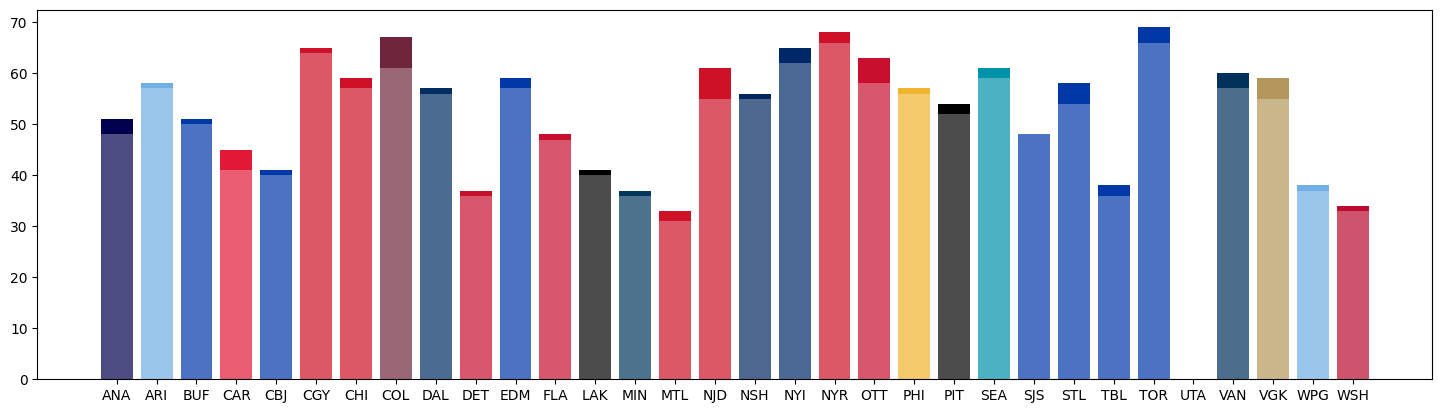

In [241]:
# rush_shots_by_team
fig, ax = plt.subplots()
ax.bar(rush_shots_by_team['abbrev'], rush_shots_by_team['count'], width=0.8, color=rush_shots_by_team['color1'], alpha=0.7)
ax.bar(rush_goals_by_team['abbrev'], rush_goals_by_team['count'], width=0.8, bottom=rush_shots_by_team['count'], color=rush_goals_by_team['color1'], alpha=1.0)
fig.set_figwidth(18)

#### Rebound goals

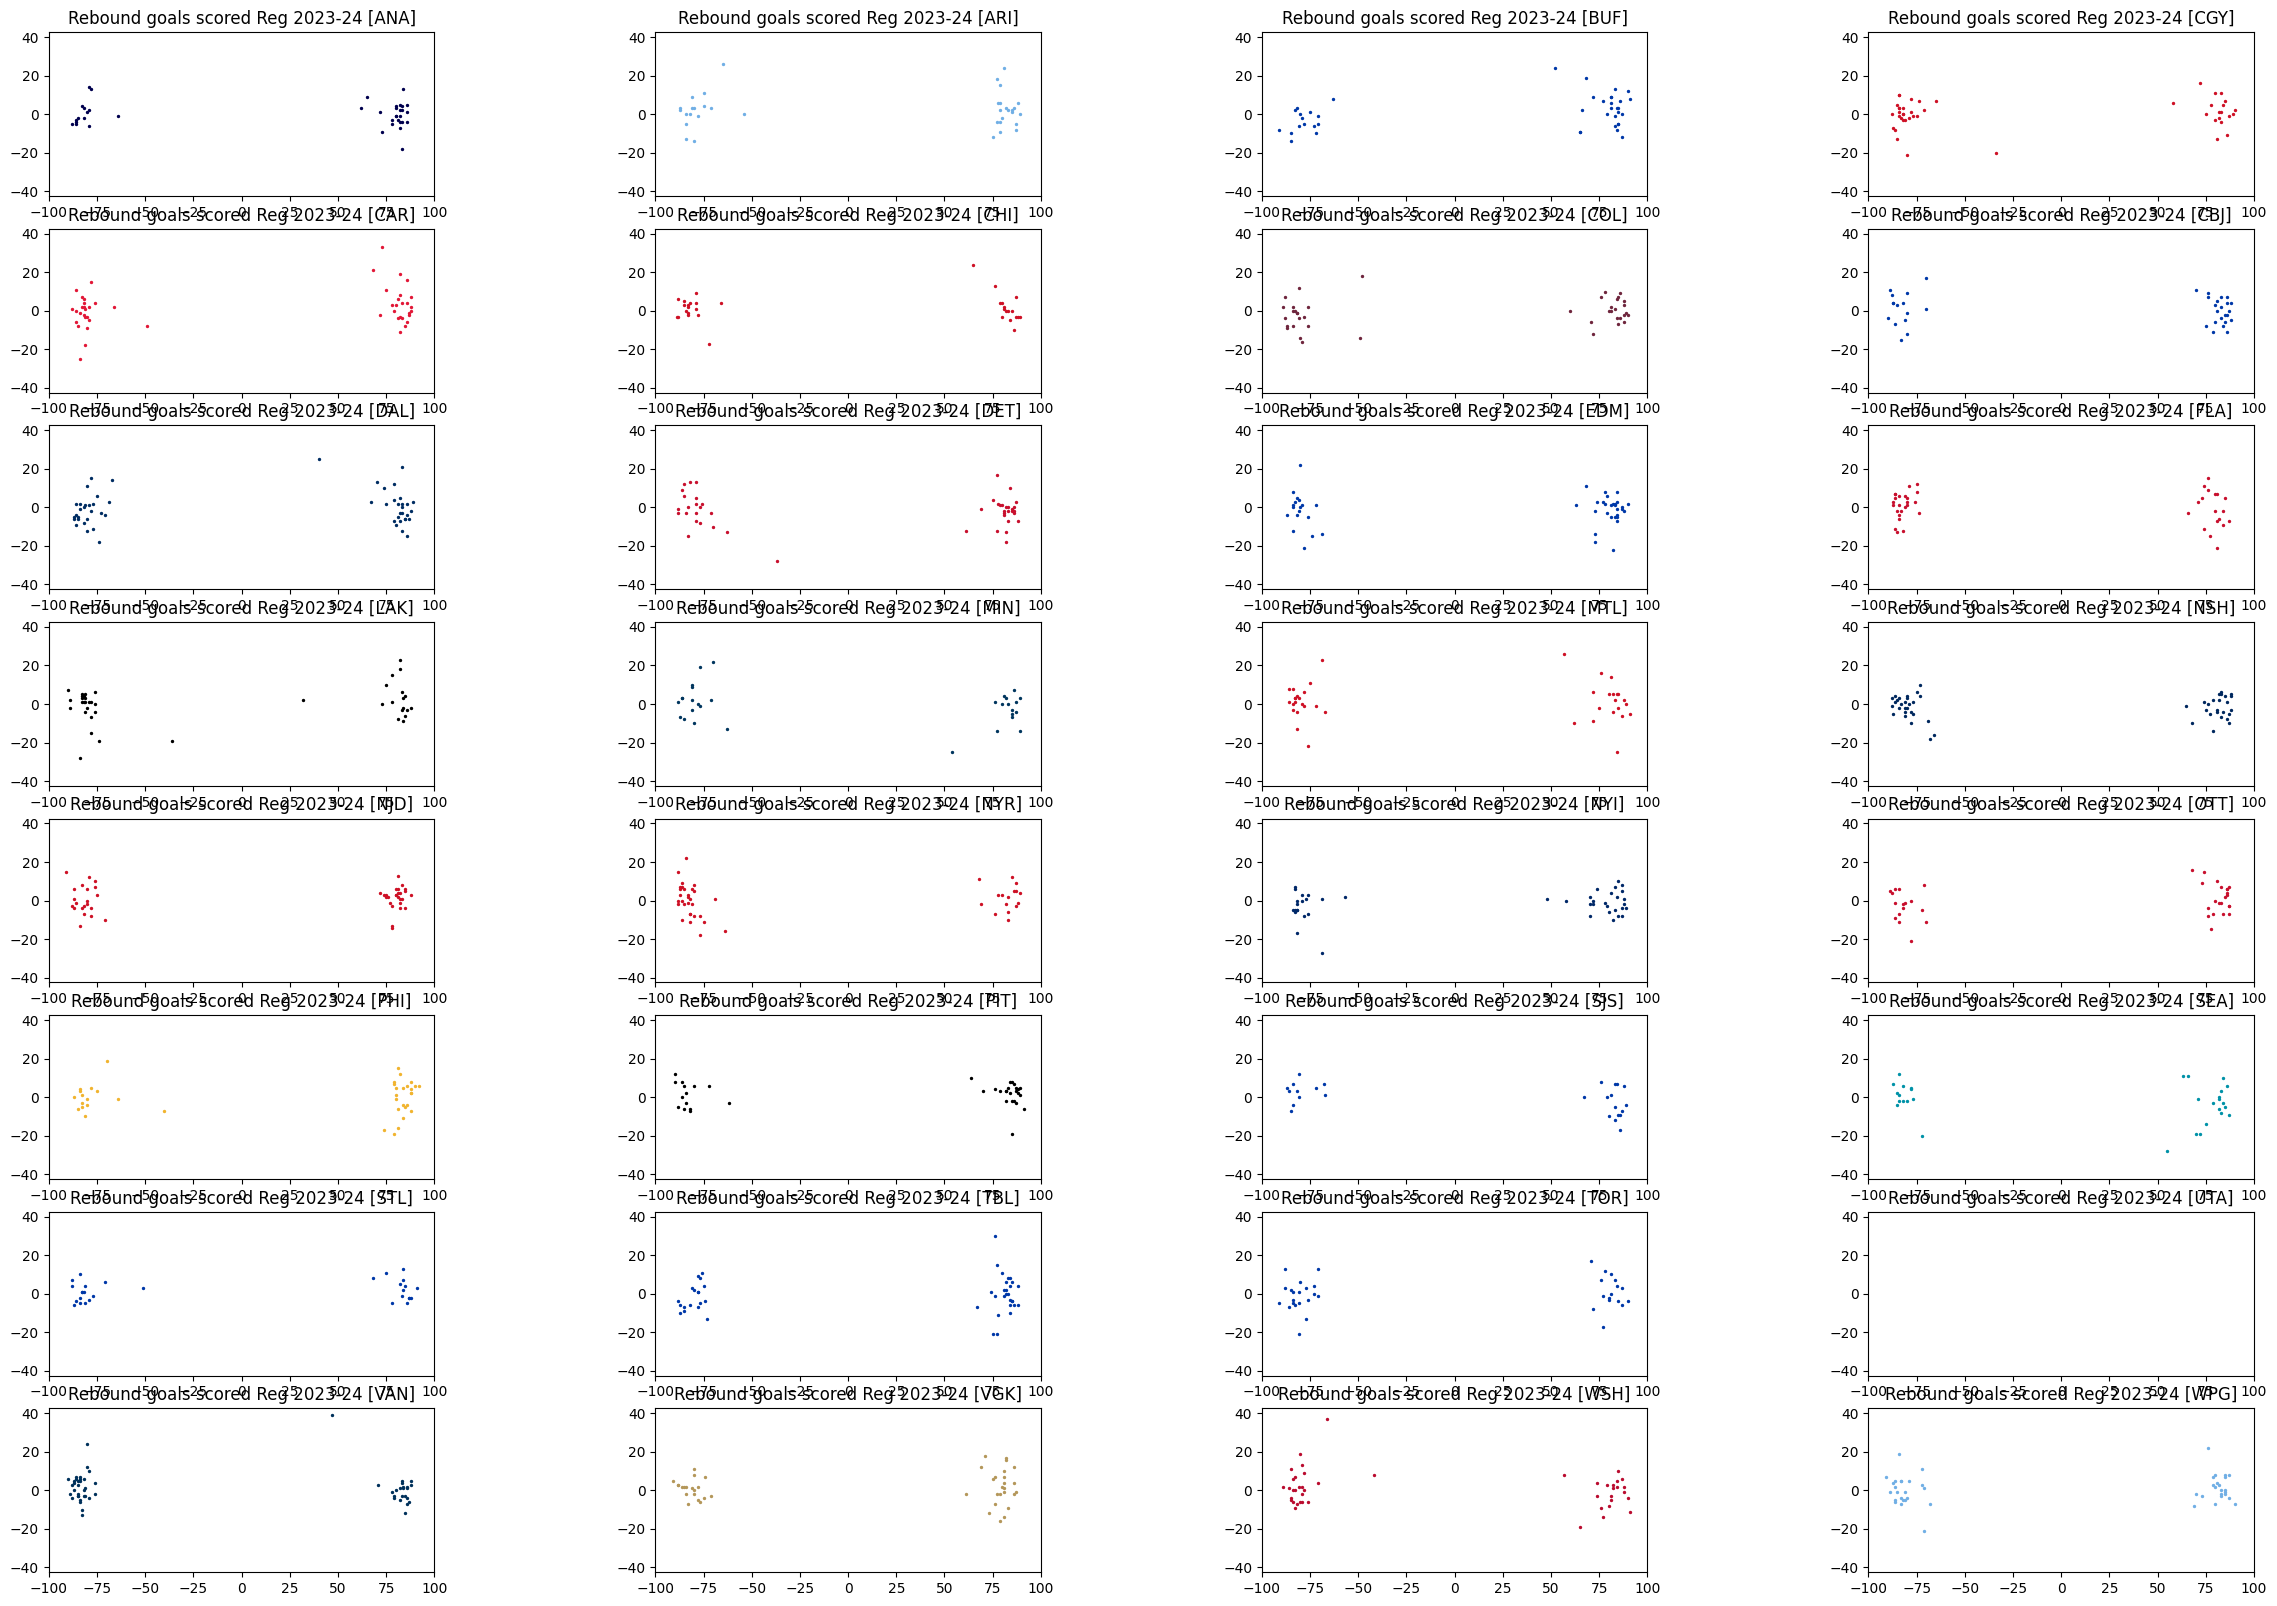

In [242]:
rebound_all = (
    plays
    .filter(pl.col('rebound') == 1)
    .filter(pl.col('season') == 20232024)
    .filter(pl.col('gameType') == 2)
)
fig, axes = draw_teams_goals(
    rebound_all.filter(pl.col('shot') == 1),
    "Rebound goals scored Reg 2023-24 [%s]",
    'goalByTeamId'
)

In [243]:
rebound_shots_by_team = get_counts_by_team(
    rebound_all
    .with_columns(shotOnly=pl.col('shot') - pl.col('goal'))
    .filter(pl.col('shotOnly') == 1)
)
rebound_goals_by_team = get_counts_by_team(rebound_all.filter(pl.col('goal') == 1))
# rebound_goals_by_team, rebound_shots_by_team

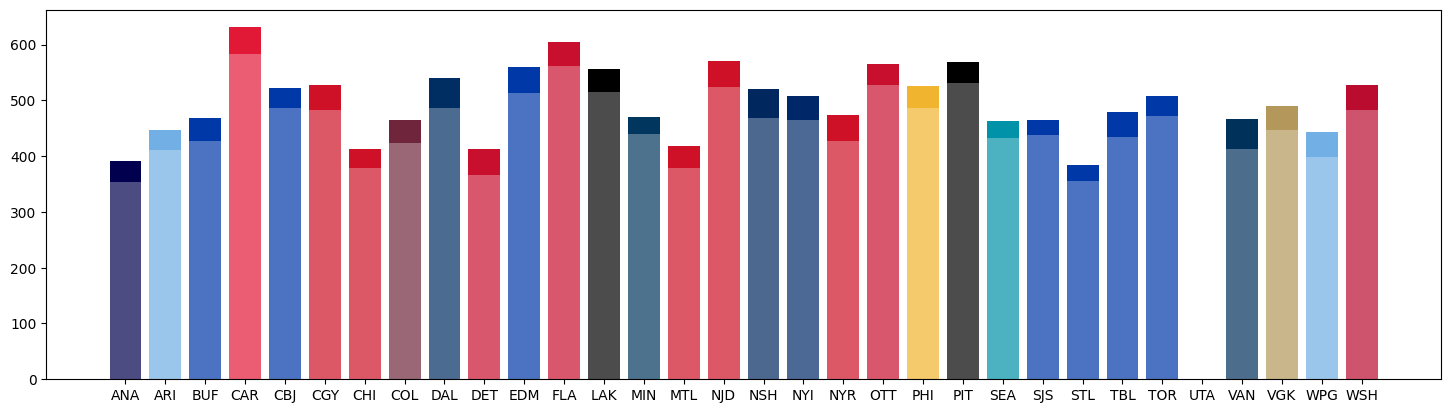

In [244]:
# rebound_shots_by_team
fig, ax = plt.subplots()
ax.bar(rebound_shots_by_team['abbrev'], rebound_shots_by_team['count'], width=0.8, color=rebound_shots_by_team['color1'], alpha=0.7)
ax.bar(rebound_goals_by_team['abbrev'], rebound_goals_by_team['count'], width=0.8, bottom=rebound_shots_by_team['count'], color=rebound_goals_by_team['color1'], alpha=1.0)
fig.set_figwidth(18)

# xG Attempt 1: Logistic Regression

In [9]:
_play_example = plays.head(1).collect()
_play_example

gameId,eventId,period,periodType,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,homeTeamDefendingSide,assist1PlayerId,assist1PlayerTotal,assist2PlayerId,assist2PlayerTotal,awaySOG,awayScore,blockingPlayerId,committedByPlayerId,descKey,discreteClip,drawnByPlayerId,duration,eventOwnerTeamId,goalieInNetId,highlightClip,highlightClipFr,highlightClipSharingUrl,highlightClipSharingUrlFr,hitteePlayerId,hittingPlayerId,homeSOG,homeScore,losingPlayerId,playerId,reason,scoringPlayerId,scoringPlayerTotal,…,timeRemainingSec,numOtPeriods,numRegPeriods,otLengthSec,timeSinceStartSec,goalByTeamId,shotByTeamId,homeGf,awayGf,homeCf,awayCf,homeBlocked,awayBlocked,homeMiss,awayMiss,homeSog,awaySog,homeFf,awayFf,lastXCoord,lastYCoord,lastHomeShotXCoord,lastAwayShotXCoord,lastHomeShotYCoord,lastAwayShotYCoord,lastTimeRemainingSec,lastHomeShotTimeRemainingSec,lastAwayShotTimeRemainingSec,deltaTime,deltaTimeHomeShot,deltaTimeAwayShot,deltaXCoord,deltaYCoord,deltaDist,rush,rebound,speed
i64,i64,i64,str,str,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,i64,i64,…,i64,i64,i64,i32,i64,i64,i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i32,i32,f64
2022020320,8,1,"""REG""","""20:00""","""1551""",520,"""period-start""",8,"""left""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1200,0,1,300,0,null,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,1200,null,null,0,null,null,null,null,null,0,0,null


In [10]:
_play_example.columns

['gameId',
 'eventId',
 'period',
 'periodType',
 'timeRemaining',
 'situationCode',
 'typeCode',
 'typeDescKey',
 'sortOrder',
 'homeTeamDefendingSide',
 'assist1PlayerId',
 'assist1PlayerTotal',
 'assist2PlayerId',
 'assist2PlayerTotal',
 'awaySOG',
 'awayScore',
 'blockingPlayerId',
 'committedByPlayerId',
 'descKey',
 'discreteClip',
 'drawnByPlayerId',
 'duration',
 'eventOwnerTeamId',
 'goalieInNetId',
 'highlightClip',
 'highlightClipFr',
 'highlightClipSharingUrl',
 'highlightClipSharingUrlFr',
 'hitteePlayerId',
 'hittingPlayerId',
 'homeSOG',
 'homeScore',
 'losingPlayerId',
 'playerId',
 'reason',
 'scoringPlayerId',
 'scoringPlayerTotal',
 'secondaryReason',
 'shootingPlayerId',
 'shotType',
 'typeCode_right',
 'winningPlayerId',
 'xCoord',
 'yCoord',
 'zoneCode',
 'homeTeamId',
 'awayTeamId',
 'gameType',
 'season',
 'eventBy',
 'goal',
 'shot',
 'block',
 'miss',
 'homeEn',
 'awayEn',
 'homeSkt',
 'awaySkt',
 'timeRemainingSec',
 'numOtPeriods',
 'numRegPeriods',
 'otLeng

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale, StandardScaler

shots_table = (
    plays
    .filter(pl.col('shot') == 1)
    # rush, rebound, deltaTime, speed, deltaTimeShot, strength (skaters + goalie), oppStrength, 
    .
)

X = (
    plays
    .select([
        'rush'
        'rebound'
        'deltaTime'
        'deltaDist',
        'speed',
        '',
        'pp',
        'en',
        'deltad',
        'xcoord',
        'ycoord',
    ])
    .with_columns(
        speed=pl.when(pl.col('speed').is_infinite()).then(pl.lit(0)).otherwise(pl.col('speed')),
        pp=pl.col('pp').cast(int),
        en=pl.col('en').cast(int),
    )
    .fill_nan(0).fill_null(0).collect().to_pandas()
)

y = cfeatures.select(['goal']).collect().to_pandas()
# X.shape, y.shape
y['goal'].value_counts()

ColumnNotFoundError: rushrebounddeltaTimedeltaDist

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
FILTER [(col("shot")) == (1)]
FROM
   WITH_COLUMNS:
   [[(col("deltaDist")) / (col("deltaTime").cast(Float64))].alias("speed")] 
     WITH_COLUMNS:
     [[([(col("lastXCoord")) - (col("xCoord"))].pow([dyn int: 2])) + ([(col("lastYCoord")) - (col("yCoord"))].pow([dyn int: 2]))].pow([dyn float: 0.5]).alias("deltaDist"), when([([([([(col("xCoord")) * (col("lastXCoord"))]) < (0)]) & ([(col("shot")) == (1)])]) & ([(col("deltaTime")) < (4)])]).then(dyn int: 1).otherwise(dyn int: 0).alias("rush"), when([([([([(col("xCoord")) * (col("lastXCoord"))]) > (0)]) & ([(col("shot")) == (1)])]) & ([([(col("deltaTimeHomeShot")) < (4)]) | ([(col("deltaTimeAwayShot")) < (4)])])]).then(dyn int: 1).otherwise(dyn int: 0).alias("rebound")] 
       WITH_COLUMNS:
       [[(col("lastTimeRemainingSec")) - (col("timeRemainingSec"))].alias("deltaTime"), [(col("lastHomeShotTimeRemainingSec")) - (col("timeRemainingSec"))].alias("deltaTimeHomeShot"), [(col("lastAwayShotTimeRemainingSec")) - (col("timeRemainingSec"))].alias("deltaTimeAwayShot"), [(col("lastXCoord")) - (col("xCoord"))].alias("deltaXCoord"), [(col("lastYCoord")) - (col("yCoord"))].alias("deltaYCoord")] 
         WITH_COLUMNS:
         [col("xCoord").shift([dyn int: 1]).over([col("gameId"), col("period")]).fill_null([0]).alias("lastXCoord"), col("yCoord").shift([dyn int: 1]).over([col("gameId"), col("period")]).fill_null([0]).alias("lastYCoord"), when([([(col("homeTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("xCoord")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastHomeShotXCoord"), when([([(col("awayTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("xCoord")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastAwayShotXCoord"), when([([(col("homeTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("yCoord")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastHomeShotYCoord"), when([([(col("awayTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("yCoord")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastAwayShotYCoord"), col("timeRemainingSec").shift([dyn int: 1]).over([col("gameId"), col("period")]).fill_null([1200]).alias("lastTimeRemainingSec"), when([([(col("homeTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("timeRemainingSec")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastHomeShotTimeRemainingSec"), when([([(col("awayTeamId")) == (col("eventOwnerTeamId"))]) & ([(col("shot")) == (1)])]).then(col("timeRemainingSec")).otherwise(null.strict_cast(Int64)).forward_fill().shift([dyn int: 1]).over([col("gameId"), col("period")]).alias("lastAwayShotTimeRemainingSec")] 
           WITH_COLUMNS:
           [[([(col("homeCf")) - (col("homeBlocked"))]) - (col("homeMiss"))].alias("homeSog"), [([(col("awayCf")) - (col("awayBlocked"))]) - (col("awayMiss"))].alias("awaySog"), [(col("homeCf")) - (col("homeBlocked"))].alias("homeFf"), [(col("awayCf")) - (col("awayBlocked"))].alias("awayFf")] 
             WITH_COLUMNS:
             [col("homeGf").cum_sum().over([col("gameId")]).alias("homeGf"), col("awayGf").cum_sum().over([col("gameId")]).alias("awayGf"), col("homeCf").cum_sum().over([col("gameId")]).alias("homeCf"), col("awayCf").cum_sum().over([col("gameId")]).alias("awayCf"), col("homeBlocked").cum_sum().over([col("gameId")]).alias("homeBlocked"), col("awayBlocked").cum_sum().over([col("gameId")]).alias("awayBlocked"), col("homeMiss").cum_sum().over([col("gameId")]).alias("homeMiss"), col("awayMiss").cum_sum().over([col("gameId")]).alias("awayMiss")] 
               WITH_COLUMNS:
               [when([([(col("goal")) == (1)]) & ([(col("homeTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("homeGf"), when([([(col("goal")) == (1)]) & ([(col("awayTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("awayGf"), when([([(col("shot")) == (1)]) & ([(col("homeTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("homeCf"), when([([(col("shot")) == (1)]) & ([(col("awayTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("awayCf"), when([([(col("block")) == (1)]) & ([(col("homeTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("homeBlocked"), when([([(col("block")) == (1)]) & ([(col("awayTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("awayBlocked"), when([([(col("miss")) == (1)]) & ([(col("homeTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("homeMiss"), when([([(col("miss")) == (1)]) & ([(col("awayTeamId")) == (col("eventOwnerTeamId"))])]).then(dyn int: 1).otherwise(dyn int: 0).alias("awayMiss")] 
                 WITH_COLUMNS:
                 [[([([(col("numRegPeriods")) * (1200)]) + ([(col("numOtPeriods")) * (col("otLengthSec").cast(Int64))])]) - (col("timeRemainingSec"))].alias("timeSinceStartSec"), when([(col("goal")) == (1)]).then(when([(col("homeTeamId")) == (col("eventOwnerTeamId"))]).then(col("homeTeamId")).otherwise(col("awayTeamId"))).otherwise(null.strict_cast(Int64)).alias("goalByTeamId"), when([(col("shot")) == (1)]).then(when([(col("homeTeamId")) == (col("eventOwnerTeamId"))]).then(col("homeTeamId")).otherwise(col("awayTeamId"))).otherwise(null.strict_cast(Int64)).alias("shotByTeamId")] 
                   WITH_COLUMNS:
                   [when([(col("homeTeamId")) == (col("eventOwnerTeamId"))]).then("home").otherwise("away").alias("eventBy"), when([(col("typeDescKey")) == ("goal")]).then(dyn int: 1).otherwise(dyn int: 0).alias("goal"), when(col("typeDescKey").is_in([Series])).then(dyn int: 1).otherwise(dyn int: 0).alias("shot"), when([(col("typeDescKey")) == ("blocked-shot")]).then(dyn int: 1).otherwise(dyn int: 0).alias("block"), when([(col("typeDescKey")) == ("missed-shot")]).then(dyn int: 1).otherwise(dyn int: 0).alias("miss"), col("situationCode").str.starts_with(["0"]).alias("homeEn"), col("situationCode").str.ends_with(["0"]).alias("awayEn"), col("situationCode").str.slice([dyn int: 2, dyn int: 1]).str.to_integer([dyn int: 10]).alias("homeSkt"), col("situationCode").str.slice([dyn int: 1, dyn int: 1]).str.to_integer([dyn int: 10]).alias("awaySkt"), [([(col("timeRemaining").str.strptime(["raise"]).dt.hour().strict_cast(Int64)) * (60)]) + (col("timeRemaining").str.strptime(["raise"]).dt.minute().strict_cast(Int64))].alias("timeRemainingSec"), dyn int: 0.max_horizontal([[(col("period")) - (3)]]).alias("numOtPeriods"), dyn int: 3.min_horizontal([col("period")]).alias("numRegPeriods"), when([(col("gameType")) == (3)]).then(dyn int: 1200).otherwise(dyn int: 300).alias("otLengthSec")] 
                    SORT BY [col("gameId")]
                      SORT BY [col("sortOrder")]
                        FILTER col("situationCode").is_in([Series]).not()
                        FROM
                          INNER JOIN:
                          LEFT PLAN ON: [col("gameId")]
                            INNER JOIN:
                            LEFT PLAN ON: [col("gameId"), col("eventId")]
                              DF ["gameId", "eventId", "period", "periodType", ...]; PROJECT */10 COLUMNS
                            RIGHT PLAN ON: [col("gameId"), col("eventId")]
                              DF ["gameId", "eventId", "assist1PlayerId", "assist1PlayerTotal", ...]; PROJECT */37 COLUMNS
                            END INNER JOIN
                          RIGHT PLAN ON: [col("id")]
                            SELECT [col("id"), col("homeTeamId"), col("awayTeamId"), col("gameType"), col("season")]
                            FROM
                              DF ["id", "season", "gameType", "startTimeUTC", ...]; PROJECT */7 COLUMNS
                          END INNER JOIN

In [ ]:
normalized_cols = [
    'xcoord',
    'ycoord',
    'lastxcoord',
    'oppskt',
    'speed',
    'deltadnet',
    'deltat',
]
X[normalized_cols] = minmax_scale(X[normalized_cols])
X.head()

In [ ]:
# intercept for regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
feature_names = X_train.columns
num_ft = len(feature_names)

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X_train)
X_scaled[:5], # X_train[:5], feature_names

In [ ]:
clf1 = LogisticRegression(max_iter=100000)
model = clf1.fit(X_train, y_train['goal'])
# model = clf1.fit(scaler.fit_transform(X_test), y_train['goal'])

In [ ]:
y_est = model.predict(X_test)
# y_est = model.predict(scaler.fit_transform(X_test))

In [ ]:
results_X_test = pl.DataFrame(X_test)
results_y_est = pl.DataFrame(y_est).select(goal_pred=pl.col('column_0'))
results_y_test = pl.DataFrame(y_test)
# pl.concat([results_X_test, results_y_est, results_y_test], how="horizontal")
results_y_est['goal_pred'].value_counts()